In [1]:
import numpy as np
import audioflux as af
from audioflux.type import SpectralFilterBankScaleType
import math
from IPython.display import Audio, display, Image, HTML
import matplotlib.pyplot as plt
from audioflux.display import fill_spec
import PIL
from prototyping import *
from dtw import dtw
from numpy.linalg import norm
import os
plt.rcParams['figure.dpi'] = 110

In [2]:
def get_spectrogram(audio_arr):
    # Create BFT object and extract mel spectrogram
    bft_obj = af.BFT(num=128, radix2_exp=12, samplate=SAMPLE_RATE,
                     scale_type=SpectralFilterBankScaleType.MEL)

    spec_arr = bft_obj.bft(audio_arr)
    spec_arr = np.abs(spec_arr)
    return bft_obj, spec_arr

def show_spectrogram(bft_obj, spec_arr, ax):            
    img = fill_spec(spec_arr, axes=ax,
              x_coords=bft_obj.x_coords(audio_len),
              y_coords=bft_obj.y_coords(),
              x_axis='time', y_axis='log',
              title='Mel Spectrogram')
    fig.colorbar(img, ax=ax)


Target sample rate 22050
Generator sample rate 22050


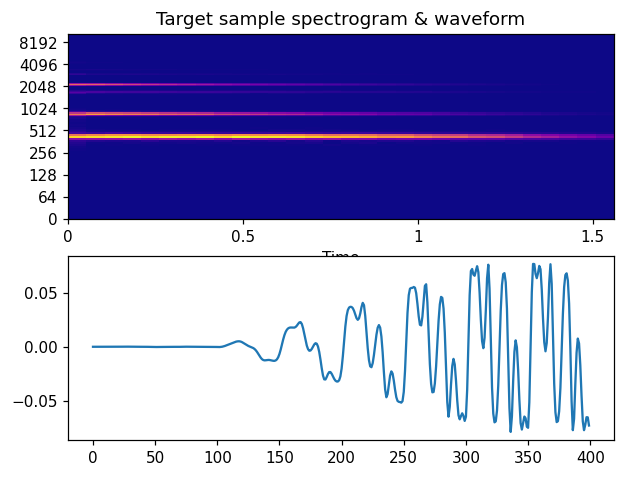

In [3]:
import librosa

fm_sample_data, fm_sample_sample_rate = librosa.load('./fm_sample.wav')
print("Target sample rate", fm_sample_sample_rate)
print("Generator sample rate", SAMPLE_RATE)

bft_obj, spec_arr = get_spectrogram(fm_sample_data)
target_sample_bft, target_sampe_spec_arr = bft_obj, spec_arr

audio_len = fm_sample_data.shape[-1]

fig, (ax, ax2) = plt.subplots(2, 1, sharex=False, sharey=False)
img = fill_spec(spec_arr, axes=ax,
          x_coords=bft_obj.x_coords(audio_len),
          y_coords=bft_obj.y_coords(),
          x_axis='time', y_axis='log',
          title='Target sample spectrogram & waveform')

ax2.plot(fm_sample_data[:400])

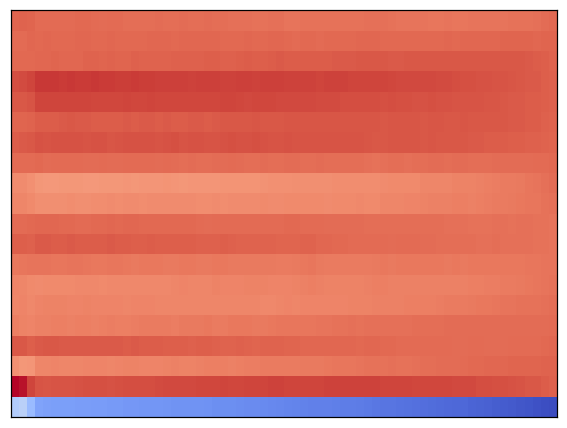

In [4]:
fm_sample_mfcc = librosa.feature.mfcc(y=fm_sample_data, sr=fm_sample_sample_rate)
librosa.display.specshow(fm_sample_mfcc)
Audio(data=fm_sample_data, rate=fm_sample_sample_rate)
# print(fm_sample_sample_rate)

New best score!
Normalized distance between the two sounds: 41897.93573148905
iteration 162


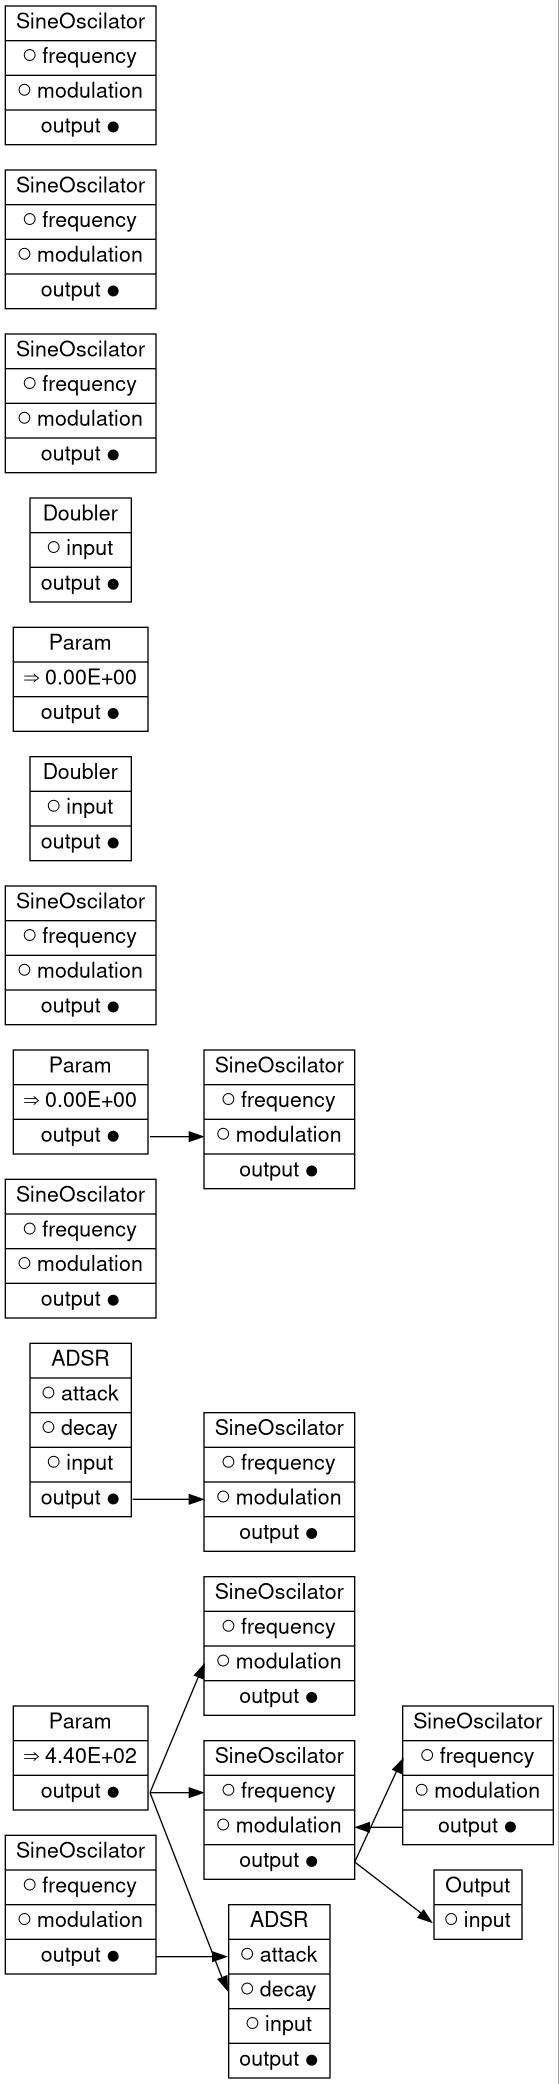

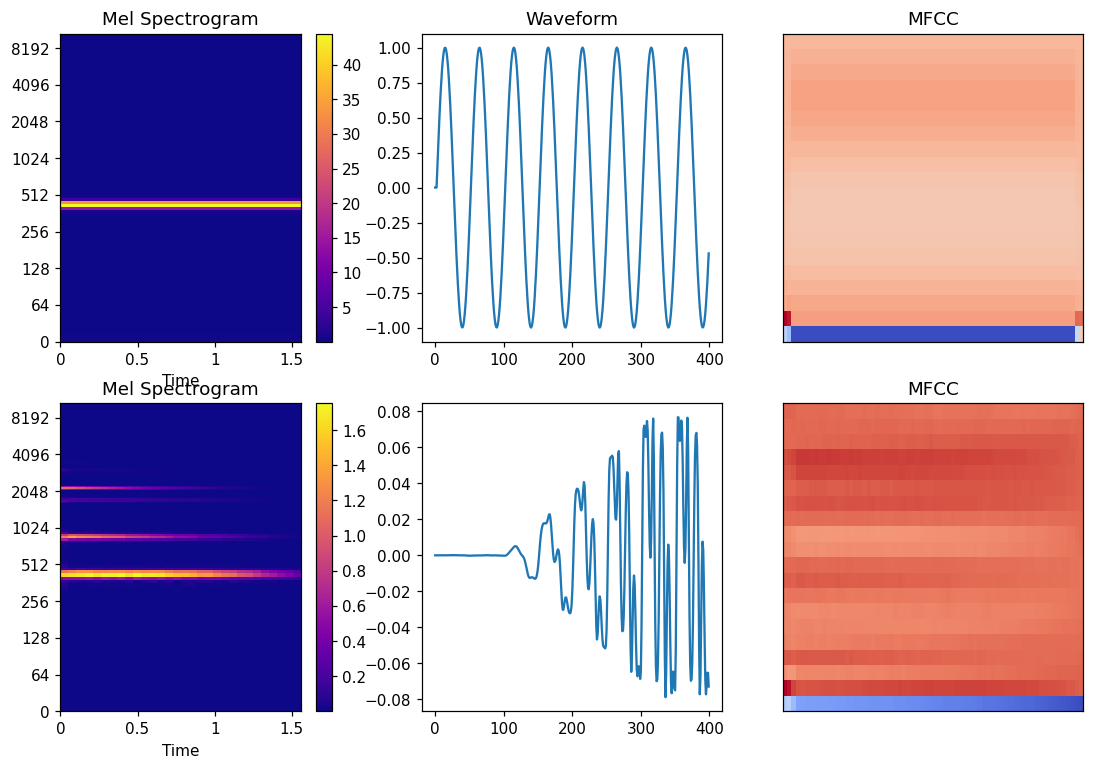

/tmp/ipykernel_11440/103456035.py:45: RuntimeWarning: invalid value encountered in divide
  audio_arr /= max(audio_arr)

KeyboardInterrupt



In [5]:
from itertools import count
from copy import deepcopy
from IPython.display import clear_output

start_graph = get_starting_graph()
current_graph = deepcopy(start_graph)
best_score = 10000000000

for iteration_number in count():
    
    # Javascript(f"document.title = 'iteration {iteration_number}';")
    graph = deepcopy(current_graph)
    graph_not_modified = deepcopy(current_graph)
    
    nodes = [SineOscilator, Doubler, ADSR, Sum, Param]

    if iteration_number > 3:
        for _ in range(random.choice([5, 10, 20, 50, 100])):
            random.choice(
                [
                    add_random_node,
                    add_random_connection,
                    add_random_connection,
                    remove_random_connection,
                    randomize_random_param,
                    nudge_random_param,
                    randomize_random_param,
                    nudge_random_param                
                ]
            )(graph)
    g = graph

    audio_arr = np.zeros(len(fm_sample_data))

    for node_id, node in graph.nodes.items():
        if isinstance(node, Output):
            output = node_id
            break

    for i in range(len(audio_arr)):
        audio_arr[i] = (g.nodes[output].inputs.input)
        g.tick()
        # time.sleep(0.01)
        
    audio_arr /= max(audio_arr)
    
    try:
        generated_audio_mfcc = librosa.feature.mfcc(y=audio_arr, sr=SAMPLE_RATE)
    except:
        # print("Cannot generate nfcc")
        continue
    dist, cost, acc_cost, path = dtw(fm_sample_mfcc.T, generated_audio_mfcc.T, dist=lambda x, y: norm(x - y, ord=1))
    dist -= len(graph.nodes)
    if dist <= best_score:
        # os.system("beep")
        clear_output()
    
    
        plt.rcParams['figure.figsize'] = [12, 8]
        print("New best score!")
        print('Normalized distance between the two sounds:', dist)

        current_graph = graph_not_modified
        best_score = dist
    
        print("iteration", iteration_number)
        display(Image(g.draw()))

        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=False, sharey=False)
        
        
        bft_obj, spec_arr = get_spectrogram(audio_arr)
        show_spectrogram(bft_obj, spec_arr, ax1)
        show_spectrogram(target_sample_bft, target_sampe_spec_arr, ax4)
        
            
        audio_len = audio_arr.shape[-1]

        ax3.set_title("MFCC")
        generated_sample_mfcc = librosa.feature.mfcc(y=audio_arr, sr=SAMPLE_RATE)
        librosa.display.specshow(generated_sample_mfcc, ax=ax3)
        
        ax6.set_title("MFCC")
        librosa.display.specshow(fm_sample_mfcc, ax=ax6)
        
        ax2.set_title("Waveform")
        ax2.plot(audio_arr[:400])
        ax5.plot(fm_sample_data[:400])
        display(Audio(data=audio_arr, rate=SAMPLE_RATE))
        display(Audio(data=fm_sample_data, rate=SAMPLE_RATE))
        plt.show()
        # break
        # time.sleep(20)

In [ ]:
import librosa

y1, sr1 = librosa.load('/home/wint3rmute/code/rust/libretakt/samples/bass_5th.wav') 
y2, sr2 = librosa.load('/home/wint3rmute/code/rust/libretakt/samples/tomll.wav') 

In [ ]:
plt.subplot(1, 2, 1)
mfcc1 = librosa.feature.mfcc(y=y1, sr=sr1)
librosa.display.specshow(mfcc1)

plt.subplot(1, 2, 2)
mfcc2 = librosa.feature.mfcc(y=y2, sr=sr2)
librosa.display.specshow(mfcc2)

display(Audio(data=y1, rate=sr1))
Audio(data=y2, rate=sr2)

In [ ]:
from dtw import dtw
from numpy.linalg import norm

In [ ]:
dist, cost, acc_cost, path = dtw(mfcc1.T, mfcc2.T, dist=lambda x, y: norm(x - y, ord=1))
print('Normalized distance between the two sounds:', dist)

In [ ]:
plt.imshow(cost.T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, cost.shape[0]-0.5))
plt.ylim((-0.5, cost.shape[1]-0.5))